# Data Analysis for data scraped with `scrapeData.py`
This notebook calculates the PE ratio for the TA-35 index.
The earnings per share and the PE ratio are calculated and compared with the scraped data in order to validate the calculations.

To calculate the earnings for a single company, it is important to take the trailing twelve months earnings per share. For June 2024, this can be calculated as follows:
$$\mathrm{Net\ Income} = \mathrm{Net\ Income\ (June \ 2024)} + (\mathrm{Net\ Income\ (Annual \ 2023)} - \mathrm{Net\ Income\ (June \ 2023)})$$

These values for the trailing twelve months earnings can then be used to calculate the PE ratio for the entire fund:
$$\mathrm{PE\ Ratio} = \frac{\sum \mathrm{Market\ Cap}_i \cdot w_i}{\sum \mathrm{Net\ Income}_i \cdot w_i}$$
where $w_i$ is the weight of the $i$-th company in the fund.


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

download_dir = Path.cwd() / 'data'

In [2]:
file = download_dir / 'dailyreviewforeignexchange.csv'
df = pd.read_csv(file, header=2, index_col=0)
usd_to_ils = df.loc['U.S Dollar', 'Exchange Rate']

In [3]:
file = download_dir / 'indexcomponents.csv'
df = pd.read_csv(file, header=2)
df.columns = df.columns.str.strip()  # remove space from column names
df = df[['Symbol', 'Security No', 'Weight (%)', 'Base Price (0.01 NIS)',
         'Market Cap (NIS millions)', 'Closing Price (0.01 NIS)']]
df['Base Price'] = df['Base Price (0.01 NIS)']
df['Market Cap'] = df['Market Cap (NIS millions)'] * 1e6
df.drop(columns=['Base Price (0.01 NIS)', 'Market Cap (NIS millions)'], inplace=True)
df['Shares'] = df['Market Cap'] / df['Base Price']

In [4]:
net_income_year = []
net_income_half_year = []
earnings_per_share = []
pe_ratio = []
dividends = []

for i in range(len(df)):
    symbol = df['Symbol'].iloc[i]
    file = download_dir / f'{symbol}FinanceReport.csv'

    df_company = pd.read_csv(file, header=0).T
    usd = 'USD' in df_company.index[0]
    multiplier = usd_to_ils if usd else 1
    df_company = pd.read_csv(file, header=1).T
    df_company = df_company.iloc[:, 1:]
    df_company.columns = df_company.iloc[0]
    df_company = df_company[1:]

    cols = ['Income Attributable to Shareholders', 'Net Income', 'Net profit']
    found = False
    for col in cols:
        if col in df_company.columns:
            values = [df_company.iloc[[i]][col].item() for i in range(3)]
            values = [float(value.replace(',', '')) * multiplier for value in values]
            net_income_year.append(values[0] + values[2] - values[1])
            net_income_half_year.append(values[0])
            found = True
            break

    if not found:
        raise ValueError('Net Income not found for ' + symbol)

    df_company = df_company.iloc[[0]]
    earnings_per_share.append(float(df_company['Earnings per Share'].item().replace(',', '')) * multiplier)
    foo = df_company['Price-Earning Ratio'].item()
    foo = float(foo) if foo != 'Loss' else np.nan
    pe_ratio.append(foo)
    dividends.append(float(df_company['Dividends'].item().replace(',', '')) * multiplier)

df['Net Income (year)'] = np.array(net_income_year) * 1000
df['Net Income (half year)'] = np.array(net_income_half_year) * 1000
df['Earnings per Share'] = np.array(earnings_per_share) * 1000 / 10  # correction
df['PE Ratio'] = np.array(pe_ratio)
df['Dividends'] = np.array(dividends) * 1000

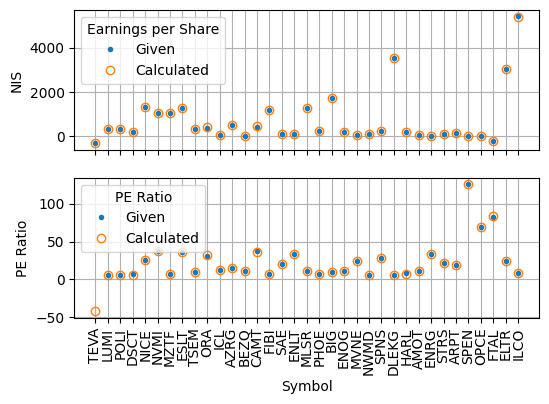

In [5]:
eps_half_year = df['Net Income (half year)'] / df['Shares']
fig, axs = plt.subplots(2,1, figsize=(6,4), sharex=True)

ax = axs[0]
ax.plot(range(len(df)), df['Earnings per Share'], '.', label='Given')
ax.plot(range(len(df)), eps_half_year, 'o', mfc='none', label='Calculated')
ax.set_ylabel('NIS')
ax.legend(title='Earnings per Share')

eps_year = df['Net Income (year)'] / df['Shares']
pe_ratio = df['Base Price'] / eps_year
ax = axs[1]
ax.plot(range(len(df)), df['PE Ratio'], '.', label='Given')
ax.plot(range(len(df)), pe_ratio, 'o', mfc='none', label='Calculated')
ax.set_xlabel('Symbol')
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df['Symbol'], rotation=90)
ax.set_ylabel('PE Ratio')
ax.legend(title='PE Ratio', loc='upper left')

for ax_ in axs:
    ax_.grid()

Note: the scraped PE ratio for a company at loss is not registered. This notebook allows for the calculation of the PE ratio for such companies and is taken into account in the calculation of the fund PE ratio.

In [6]:
# Weighted average of prices to weighted average of earnings
fund_pe_ratio = (df['Market Cap'] * df['Weight (%)']).sum() / (df['Net Income (year)'] * df['Weight (%)']).sum()
print(f'Fund PE Ratio: {fund_pe_ratio:.1f}')

Fund PE Ratio: 12.5
